Seismic Image Classification - Deep Neural Network
---------------------------------------------

### Load required libraries

In [1]:
# Let's import the libraries required for the image classification
import os
import glob
RAND_SEED = 1234
import numpy as np
np.random.seed(RAND_SEED)
import tensorflow as tf
tf.random.set_seed(RAND_SEED)
import random
random.seed(RAND_SEED)
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Load data from files

In [2]:
IMG_DIM = 96
IMG_PER_CLASS = 500
TEST_SPLIT_FRAC = 0.1
TRAIN_SPLIT_FRAC = 0.9
BATCH_SIZE = 32
NUM_CLASSES = 3

data_dir = './data'
class_names = ['fault', 'salt', 'other']
file_list = []

for class_name in class_names:
    class_files = glob.glob(data_dir + os.path.sep + \
                            class_name + os.path.sep + '*.png')
    for f in class_files:
        file_list.append(f)

def get_class_label(file_path):
    # Split file path to get directory and file names.
    path_split = file_path.split(os.path.sep)
    # The second-last string contains name of the class directory;
    # Use it to create class label.
    return class_names.index(path_split[-2].strip())

def decode_image(img):
    # Convert the passed image to a uint8 tensor;
    # Using 1 channel, as the images are grayscale.
    img = tf.image.decode_png(img, channels=1)
    # Convert image to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the predefined image size.
    return tf.image.resize(img, [IMG_DIM, IMG_DIM]).numpy()

def process_file_path(file_path):
    label = get_class_label(file_path)
    # Load data from the image file.
    img = tf.io.read_file(file_path)
    # Decode and convert image data to float32.
    img = decode_image(img)
    return img, label

images = []
labels = []
for f in file_list:
    img, label = process_file_path(f)
    images.append(img)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

### Create training, validation, and test data sets

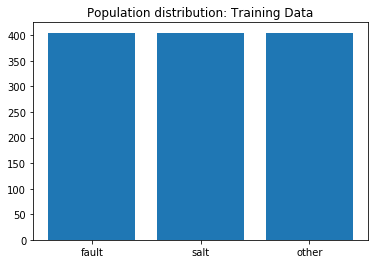

In [3]:
def split_datasets(images, labels):
    # Split data into train, validation, and test data sets.
    X_rest, X_test, y_rest, y_test = \
    train_test_split(images, labels, test_size=TEST_SPLIT_FRAC, 
                     random_state=RAND_SEED, stratify=labels)
    X_train, X_valid, y_train, y_valid = \
    train_test_split(X_rest, y_rest, train_size=TRAIN_SPLIT_FRAC, 
                     random_state=RAND_SEED, stratify=y_rest)
    return X_train, X_valid, X_test, y_train, y_valid, y_test
    
X_train, X_valid, X_test, y_train, y_valid, y_test = \
split_datasets(images, labels)

# Plot class population distribution in the training data
# Calculate population of three classes
population = [len(np.where(y_train == 0)[0]), 
              len(np.where(y_train == 1)[0]),
              len(np.where(y_train == 2)[0])]
# Plot
plt.bar(class_names, population)
plt.title('Population distribution: Training Data')

# determine the number of input features
n_features = IMG_DIM * IMG_DIM
n_train = population[0] + population[1] + population[2]
n_test = int(NUM_CLASSES * IMG_PER_CLASS * TEST_SPLIT_FRAC)
n_valid = NUM_CLASSES * IMG_PER_CLASS - n_train - n_test
X_train = np.reshape(X_train, (n_train, n_features))
X_valid = np.reshape(X_valid, (n_valid, n_features))
X_test = np.reshape(X_test, (n_test, n_features))

### Visualize Training Images

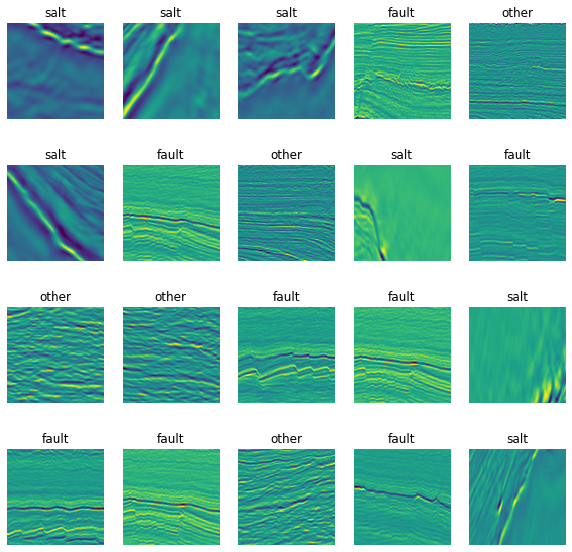

In [4]:
def show_training_images(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(X_train[i].reshape((IMG_DIM, IMG_DIM)))
        plt.title(class_names[y_train[i]])
        plt.axis('off')

show_training_images(X_train, y_train)

### Build and train a Deep Neural Network model

In [5]:
# Define a Deep Neural Network model
reg_param = 0.02 # Regularization parameter for L2 regularization
model = Sequential()
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param), input_shape=(n_features,)))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal', 
                kernel_regularizer=l2(l=reg_param)))
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='Adadelta', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Early-stopping callback using validation
earlystop_callback = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001,
    patience=50)
# Save the best model
ckpt_path = './models/dnn.h5'
ckpt_callback = ModelCheckpoint(filepath=ckpt_path, mode='max', 
                                monitor='val_accuracy', verbose=1, 
                                save_best_only=True)
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[earlystop_callback, ckpt_callback], 
                    verbose=1)

Train on 1215 samples, validate on 135 samples
Epoch 1/500
1120/1215 [==========================>...] - ETA: 0s - loss: 82.7574 - accuracy: 0.3571
Epoch 00001: val_accuracy improved from -inf to 0.48148, saving model to ./models/dnn.h5
1215/1215 [==============================] - 1s 1ms/sample - loss: 82.7521 - accuracy: 0.3621 - val_loss: 82.6771 - val_accuracy: 0.4815
Epoch 2/500
1120/1215 [==========================>...] - ETA: 0s - loss: 82.6183 - accuracy: 0.4491
Epoch 00002: val_accuracy did not improve from 0.48148
1215/1215 [==============================] - 0s 158us/sample - loss: 82.6138 - accuracy: 0.4477 - val_loss: 82.5443 - val_accuracy: 0.3778
Epoch 3/500
1088/1215 [=========================>....] - ETA: 0s - loss: 82.4851 - accuracy: 0.4697
Epoch 00003: val_accuracy did not improve from 0.48148
1215/1215 [==============================] - 0s 158us/sample - loss: 82.4781 - accuracy: 0.4658 - val_loss: 82.4037 - val_accuracy: 0.4444
Epoch 4/500
1088/1215 [================

1088/1215 [=========================>....] - ETA: 0s - loss: 79.1903 - accuracy: 0.6186
Epoch 00028: val_accuracy did not improve from 0.58519
1215/1215 [==============================] - 0s 171us/sample - loss: 79.1839 - accuracy: 0.6230 - val_loss: 79.1564 - val_accuracy: 0.4741
Epoch 29/500
1024/1215 [========================>.....] - ETA: 0s - loss: 79.0610 - accuracy: 0.6309
Epoch 00029: val_accuracy did not improve from 0.58519
1215/1215 [==============================] - 0s 169us/sample - loss: 79.0529 - accuracy: 0.6230 - val_loss: 79.0135 - val_accuracy: 0.5778
Epoch 30/500
1056/1215 [=========================>....] - ETA: 0s - loss: 78.9300 - accuracy: 0.6146
Epoch 00030: val_accuracy did not improve from 0.58519
1215/1215 [==============================] - 0s 189us/sample - loss: 78.9219 - accuracy: 0.6165 - val_loss: 78.8862 - val_accuracy: 0.5630
Epoch 31/500
1088/1215 [=========================>....] - ETA: 0s - loss: 78.8008 - accuracy: 0.6379
Epoch 00031: val_accuracy d

Epoch 56/500
1056/1215 [=========================>....] - ETA: 0s - loss: 75.6427 - accuracy: 0.6847
Epoch 00056: val_accuracy did not improve from 0.63704
1215/1215 [==============================] - 0s 163us/sample - loss: 75.6327 - accuracy: 0.6914 - val_loss: 75.6218 - val_accuracy: 0.5481
Epoch 57/500
1088/1215 [=========================>....] - ETA: 0s - loss: 75.5158 - accuracy: 0.6884
Epoch 00057: val_accuracy did not improve from 0.63704
1215/1215 [==============================] - 0s 163us/sample - loss: 75.5095 - accuracy: 0.6823 - val_loss: 75.5061 - val_accuracy: 0.5481
Epoch 58/500
1088/1215 [=========================>....] - ETA: 0s - loss: 75.3893 - accuracy: 0.7040
Epoch 00058: val_accuracy did not improve from 0.63704
1215/1215 [==============================] - 0s 166us/sample - loss: 75.3843 - accuracy: 0.7029 - val_loss: 75.4175 - val_accuracy: 0.4593
Epoch 59/500
 992/1215 [=======================>......] - ETA: 0s - loss: 75.2702 - accuracy: 0.6875
Epoch 00059: v

Epoch 84/500
1152/1215 [===========================>..] - ETA: 0s - loss: 72.2537 - accuracy: 0.7431
Epoch 00084: val_accuracy did not improve from 0.63704
1215/1215 [==============================] - 0s 155us/sample - loss: 72.2496 - accuracy: 0.7440 - val_loss: 72.2636 - val_accuracy: 0.5778
Epoch 85/500
1088/1215 [=========================>....] - ETA: 0s - loss: 72.1386 - accuracy: 0.7325
Epoch 00085: val_accuracy did not improve from 0.63704
1215/1215 [==============================] - 0s 161us/sample - loss: 72.1333 - accuracy: 0.7383 - val_loss: 72.1507 - val_accuracy: 0.5778
Epoch 86/500
1088/1215 [=========================>....] - ETA: 0s - loss: 72.0235 - accuracy: 0.7381
Epoch 00086: val_accuracy did not improve from 0.63704
1215/1215 [==============================] - 0s 169us/sample - loss: 72.0164 - accuracy: 0.7440 - val_loss: 72.0390 - val_accuracy: 0.5778
Epoch 87/500
 992/1215 [=======================>......] - ETA: 0s - loss: 71.9072 - accuracy: 0.7248
Epoch 00087: v

Epoch 112/500
 992/1215 [=======================>......] - ETA: 0s - loss: 69.0594 - accuracy: 0.7661
Epoch 00112: val_accuracy did not improve from 0.65926
1215/1215 [==============================] - 0s 185us/sample - loss: 69.0497 - accuracy: 0.7720 - val_loss: 69.0860 - val_accuracy: 0.6519
Epoch 113/500
1024/1215 [========================>.....] - ETA: 0s - loss: 68.9503 - accuracy: 0.7793
Epoch 00113: val_accuracy did not improve from 0.65926
1215/1215 [==============================] - 0s 175us/sample - loss: 68.9403 - accuracy: 0.7778 - val_loss: 68.9967 - val_accuracy: 0.5481
Epoch 114/500
 960/1215 [======================>.......] - ETA: 0s - loss: 68.8341 - accuracy: 0.7812
Epoch 00114: val_accuracy did not improve from 0.65926
1215/1215 [==============================] - 0s 191us/sample - loss: 68.8270 - accuracy: 0.7712 - val_loss: 68.8596 - val_accuracy: 0.6296
Epoch 115/500
1152/1215 [===========================>..] - ETA: 0s - loss: 68.7211 - accuracy: 0.7795
Epoch 0011

Epoch 140/500
1056/1215 [=========================>....] - ETA: 0s - loss: 66.0306 - accuracy: 0.7917
Epoch 00140: val_accuracy did not improve from 0.67407
1215/1215 [==============================] - 0s 164us/sample - loss: 66.0244 - accuracy: 0.7885 - val_loss: 66.0789 - val_accuracy: 0.6667
Epoch 141/500
1088/1215 [=========================>....] - ETA: 0s - loss: 65.9220 - accuracy: 0.8079
Epoch 00141: val_accuracy did not improve from 0.67407
1215/1215 [==============================] - 0s 164us/sample - loss: 65.9187 - accuracy: 0.8066 - val_loss: 65.9726 - val_accuracy: 0.6444
Epoch 142/500
1024/1215 [========================>.....] - ETA: 0s - loss: 65.8188 - accuracy: 0.7998
Epoch 00142: val_accuracy did not improve from 0.67407
1215/1215 [==============================] - 0s 173us/sample - loss: 65.8166 - accuracy: 0.7934 - val_loss: 65.8670 - val_accuracy: 0.6222
Epoch 143/500
1056/1215 [=========================>....] - ETA: 0s - loss: 65.7162 - accuracy: 0.7973
Epoch 0014

Epoch 168/500
1152/1215 [===========================>..] - ETA: 0s - loss: 63.1984 - accuracy: 0.8168
Epoch 00168: val_accuracy did not improve from 0.70370
1215/1215 [==============================] - 0s 155us/sample - loss: 63.1930 - accuracy: 0.8181 - val_loss: 63.2727 - val_accuracy: 0.6296
Epoch 169/500
1088/1215 [=========================>....] - ETA: 0s - loss: 63.1034 - accuracy: 0.8171
Epoch 00169: val_accuracy did not improve from 0.70370
1215/1215 [==============================] - 0s 160us/sample - loss: 63.0984 - accuracy: 0.8189 - val_loss: 63.1847 - val_accuracy: 0.6296
Epoch 170/500
 992/1215 [=======================>......] - ETA: 0s - loss: 63.0096 - accuracy: 0.8196
Epoch 00170: val_accuracy did not improve from 0.70370
1215/1215 [==============================] - 0s 170us/sample - loss: 63.0021 - accuracy: 0.8189 - val_loss: 63.1009 - val_accuracy: 0.6370
Epoch 171/500
1088/1215 [=========================>....] - ETA: 0s - loss: 62.9025 - accuracy: 0.8336
Epoch 0017

Epoch 196/500
1088/1215 [=========================>....] - ETA: 0s - loss: 60.5568 - accuracy: 0.8447
Epoch 00196: val_accuracy did not improve from 0.70370
1215/1215 [==============================] - 0s 166us/sample - loss: 60.5508 - accuracy: 0.8428 - val_loss: 60.6571 - val_accuracy: 0.6815
Epoch 197/500
 928/1215 [=====================>........] - ETA: 0s - loss: 60.4784 - accuracy: 0.8373
Epoch 00197: val_accuracy did not improve from 0.70370
1215/1215 [==============================] - 0s 195us/sample - loss: 60.4590 - accuracy: 0.8469 - val_loss: 60.5554 - val_accuracy: 0.6741
Epoch 198/500
1024/1215 [========================>.....] - ETA: 0s - loss: 60.3768 - accuracy: 0.8525
Epoch 00198: val_accuracy did not improve from 0.70370
1215/1215 [==============================] - 0s 166us/sample - loss: 60.3730 - accuracy: 0.8502 - val_loss: 60.4730 - val_accuracy: 0.6370
Epoch 199/500
1088/1215 [=========================>....] - ETA: 0s - loss: 60.2818 - accuracy: 0.8438
Epoch 0019

Epoch 224/500
1056/1215 [=========================>....] - ETA: 0s - loss: 58.0807 - accuracy: 0.8646
Epoch 00224: val_accuracy did not improve from 0.71852
1215/1215 [==============================] - 0s 167us/sample - loss: 58.0792 - accuracy: 0.8560 - val_loss: 58.1947 - val_accuracy: 0.6889
Epoch 225/500
1088/1215 [=========================>....] - ETA: 0s - loss: 57.9933 - accuracy: 0.8557
Epoch 00225: val_accuracy did not improve from 0.71852
1215/1215 [==============================] - 0s 167us/sample - loss: 57.9888 - accuracy: 0.8593 - val_loss: 58.1092 - val_accuracy: 0.6815
Epoch 226/500
1024/1215 [========================>.....] - ETA: 0s - loss: 57.9099 - accuracy: 0.8701
Epoch 00226: val_accuracy did not improve from 0.71852
1215/1215 [==============================] - 0s 171us/sample - loss: 57.9027 - accuracy: 0.8708 - val_loss: 58.0292 - val_accuracy: 0.6815
Epoch 227/500
1088/1215 [=========================>....] - ETA: 0s - loss: 57.8193 - accuracy: 0.8575
Epoch 0022

Epoch 252/500
1088/1215 [=========================>....] - ETA: 0s - loss: 55.7713 - accuracy: 0.8759
Epoch 00252: val_accuracy did not improve from 0.72593
1215/1215 [==============================] - 0s 161us/sample - loss: 55.7670 - accuracy: 0.8774 - val_loss: 55.9026 - val_accuracy: 0.6667
Epoch 253/500
1152/1215 [===========================>..] - ETA: 0s - loss: 55.6959 - accuracy: 0.8715
Epoch 00253: val_accuracy did not improve from 0.72593
1215/1215 [==============================] - 0s 156us/sample - loss: 55.6926 - accuracy: 0.8733 - val_loss: 55.8306 - val_accuracy: 0.6815
Epoch 254/500
1120/1215 [==========================>...] - ETA: 0s - loss: 55.6149 - accuracy: 0.8750
Epoch 00254: val_accuracy did not improve from 0.72593
1215/1215 [==============================] - 0s 159us/sample - loss: 55.6095 - accuracy: 0.8724 - val_loss: 55.7658 - val_accuracy: 0.7037
Epoch 255/500
1056/1215 [=========================>....] - ETA: 0s - loss: 55.5421 - accuracy: 0.8684
Epoch 0025

Epoch 280/500
1088/1215 [=========================>....] - ETA: 0s - loss: 53.6133 - accuracy: 0.8915
Epoch 00280: val_accuracy did not improve from 0.74815
1215/1215 [==============================] - 0s 162us/sample - loss: 53.6105 - accuracy: 0.8881 - val_loss: 53.7731 - val_accuracy: 0.6963
Epoch 281/500
1152/1215 [===========================>..] - ETA: 0s - loss: 53.5335 - accuracy: 0.8889
Epoch 00281: val_accuracy did not improve from 0.74815
1215/1215 [==============================] - 0s 153us/sample - loss: 53.5329 - accuracy: 0.8872 - val_loss: 53.6987 - val_accuracy: 0.6963
Epoch 282/500
1120/1215 [==========================>...] - ETA: 0s - loss: 53.4716 - accuracy: 0.8750
Epoch 00282: val_accuracy did not improve from 0.74815
1215/1215 [==============================] - 0s 162us/sample - loss: 53.4701 - accuracy: 0.8724 - val_loss: 53.6219 - val_accuracy: 0.7259
Epoch 283/500
1120/1215 [==========================>...] - ETA: 0s - loss: 53.4039 - accuracy: 0.8786
Epoch 0028

Epoch 308/500
 960/1215 [======================>.......] - ETA: 0s - loss: 51.6093 - accuracy: 0.8906
Epoch 00308: val_accuracy did not improve from 0.74815
1215/1215 [==============================] - 0s 187us/sample - loss: 51.6034 - accuracy: 0.8905 - val_loss: 51.7963 - val_accuracy: 0.6741
Epoch 309/500
1120/1215 [==========================>...] - ETA: 0s - loss: 51.5406 - accuracy: 0.8946
Epoch 00309: val_accuracy did not improve from 0.74815
1215/1215 [==============================] - 0s 154us/sample - loss: 51.5338 - accuracy: 0.8963 - val_loss: 51.7075 - val_accuracy: 0.6815
Epoch 310/500
1184/1215 [============================>.] - ETA: 0s - loss: 51.4616 - accuracy: 0.9062
Epoch 00310: val_accuracy did not improve from 0.74815
1215/1215 [==============================] - 0s 153us/sample - loss: 51.4604 - accuracy: 0.9062 - val_loss: 51.6729 - val_accuracy: 0.6519
Epoch 311/500
1056/1215 [=========================>....] - ETA: 0s - loss: 51.3981 - accuracy: 0.8977
Epoch 0031

### Review the model training

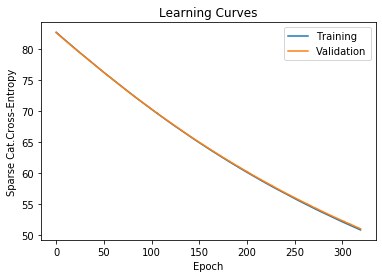

In [6]:
# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Sparse Cat.Cross-Entropy')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

### Use saved model to predict test data

In [7]:
# Evaluate the best model using test data
model = load_model(ckpt_path)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.713
